In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import pathlib
import numpy as np
import pandas as pd
import html
import re
from fastai.text import *

# Data Preparation

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm-data/wiki_extr/id")

In [4]:
LM_PATH=Path('lm-data/id/lm/')
LM_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/wiki_*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

517


['lm-data/wiki_extr/id/AA/wiki_00',
 'lm-data/wiki_extr/id/AA/wiki_01',
 'lm-data/wiki_extr/id/AA/wiki_02',
 'lm-data/wiki_extr/id/AA/wiki_03',
 'lm-data/wiki_extr/id/AA/wiki_04']

In [6]:
LANG_TEXT = []
for fn in tqdm(LANG_FILENAMES):
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

100%|██████████| 517/517 [00:05<00:00, 100.04it/s]


In [7]:
LANG_TEXT.head()

,id,text,title,url
0,1,Asam deoksiribonukleat\n\nAsam deoksiribonukle...,Asam deoksiribonukleat,https://id.wikipedia.org/wiki?curid=1
1,3,Anwar Sadat\n\nJenderal Besar Mohammed Anwar A...,Anwar Sadat,https://id.wikipedia.org/wiki?curid=3
2,4,Azhar Mansor\n\nDatuk Azhar Mansor adalah oran...,Azhar Mansor,https://id.wikipedia.org/wiki?curid=4
3,5,Arkeologi\n\nArkeologi atau ilmu kepurbakalaan...,Arkeologi,https://id.wikipedia.org/wiki?curid=5
4,6,Antropologi\n\nAntropologi adalah ilmu tentang...,Antropologi,https://id.wikipedia.org/wiki?curid=6


In [8]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus.csv", index=False)

In [9]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus.csv")

In [10]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [11]:
LANG_TEXT.head()

,id,text,title,url
0,1,"Asam deoksiribonukleat, lebih dikenal dengan s...",Asam deoksiribonukleat,https://id.wikipedia.org/wiki?curid=1
1,3,Jenderal Besar Mohammed Anwar Al Sadat (; ) ad...,Anwar Sadat,https://id.wikipedia.org/wiki?curid=3
2,4,Datuk Azhar Mansor adalah orang Malaysia perta...,Azhar Mansor,https://id.wikipedia.org/wiki?curid=4
3,5,Arkeologi atau ilmu kepurbakalaan berasal dari...,Arkeologi,https://id.wikipedia.org/wiki?curid=5
4,6,Antropologi adalah ilmu tentang manusia. Antro...,Antropologi,https://id.wikipedia.org/wiki?curid=6


In [12]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus2.csv", header=None, index=False)

Sorting the articles by length and keeping the first million (this is actually not necessary for indonesian wiki since it has less than 450k articles in 2018).

In [6]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus2.csv")

In [14]:
LANG_TEXT = LANG_TEXT.assign(length = 0)
LANG_TEXT.columns = ['id', 'text', 'title', 'url', 'length']
LANG_TEXT = LANG_TEXT.assign(labels = 0).pipe(lambda x: x[['labels', 'text', 'length']])

In [15]:
LANG_TEXT.head()

,labels,text,length
0,0,Jenderal Besar Mohammed Anwar Al Sadat (; ) ad...,0
1,0,Datuk Azhar Mansor adalah orang Malaysia perta...,0
2,0,Arkeologi atau ilmu kepurbakalaan berasal dari...,0
3,0,Antropologi adalah ilmu tentang manusia. Antro...,0
4,0,"Analisis leksikal (bahasa Inggris: ""lexical an...",0


In [16]:
LANG_TEXT['length'] = LANG_TEXT['text'].str.len()
#LANG_TEXT = LANG_TEXT.sort_values(by=['length'], ascending=False)

In [17]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus3.csv", header=False, index=False)

In [7]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus3.csv")

In [8]:
LANG_TEXT.columns = ['labels', 'text', 'length']
LANG_TEXT = LANG_TEXT[LANG_TEXT['length'] > 10]
LANG_TEXT = LANG_TEXT.drop(['length'], axis=1)

In [42]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus4.csv", header=False, index=False)

In [5]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus4.csv")

In [6]:
len(LANG_TEXT)
LANG_TEXT.columns = ['labels', 'text']
LANG_TEXT.head()

,labels,text
0,0,Arkeologi atau ilmu kepurbakalaan berasal dari...
1,0,Antropologi adalah ilmu tentang manusia. Antro...
2,0,"Analisis leksikal (bahasa Inggris: ""lexical an..."
3,0,Bahasa Indonesia adalah bahasa Melayu yang dij...
4,0,"Biologi adalah kajian tentang kehidupan, dan o..."


In [45]:
#LANG_TEXT = LANG_TEXT.iloc[0:1000000]
#LANG_TEXT.head()
#LANG_TEXT = LANG_TEXT.drop(['length'], axis=1)
#LANG_TEXT.head()

In [7]:
len(LANG_TEXT)

433388

## Some statistics of Indonesia Wikipedia

### Number of documents

In [8]:
print(LANG_TEXT['text'][:5])
LANG_TEXT.shape

0    Arkeologi atau ilmu kepurbakalaan berasal dari...
1    Antropologi adalah ilmu tentang manusia. Antro...
2    Analisis leksikal (bahasa Inggris: "lexical an...
3    Bahasa Indonesia adalah bahasa Melayu yang dij...
4    Biologi adalah kajian tentang kehidupan, dan o...
Name: text, dtype: object


(433388, 2)

### Number of words in all the documents

In [12]:
def x_split(x):
    l = 0
    try:
        l = len(x.split(" "))
    except AttributeError:
        print(x)
    return l

LANG_TEXT['text'].apply(lambda x: x_split(x)).sum()    
#LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

63431839

### Number of unique tokens across documents

In [49]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

3572013

## Tokenize

In [6]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [7]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts), lang='xx') # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [7]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Indonesia_Corpus4.csv", header=None)#, chunksize=5000)

In [8]:
print(LANG_TEXT.head())
LANG_TEXT.shape

   0                                                  1
0  0  Datuk Azhar Mansor adalah orang Malaysia perta...
1  0  Arkeologi atau ilmu kepurbakalaan berasal dari...
2  0  Antropologi adalah ilmu tentang manusia. Antro...
3  0  Analisis leksikal (bahasa Inggris: "lexical an...
4  0  Bahasa Indonesia adalah bahasa Melayu yang dij...


(433389, 2)

In [54]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [55]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [56]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [57]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4


In [58]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [64]:
print("Trn:", tok_trn[:2], "\n")

Trn: [list(['\n', 'xbos', 'xfld', '1', 'bermis', 'adalah', 'sebuah', 'stasiun', 't_up', 'brt', 'transjakarta', 'yang', 'terletak', 'di', 'jalan', 'perintis', 'kemerdekaan', ',', 'kelapa', 'gading', 'timur', ',', 'kelapa', 'gading', ',', 'jakarta', 'utara', '.', 'stasiun', 't_up', 'brt', 'ini', 'berada', 'di', 'koridor', '2', 'yang', 'membentang', 'dari', 'barat', 'ke', 'timur', '.', 'nama', 'stasiun', 't_up', 'brt', 'ini', 'berasal', 'dari', 'nama', 'daerah', 'tersebut', '.'])
 list(['\n', 'xbos', 'xfld', '1', 'don', 'marcelino', 'adalah', 'munisipalitas', 'yang', 'terletak', 'di', 'provinsi', 'davao', 'occidental', ',', 'filipina.pada', 'tahun', '2010', ',', 'munisipalitas', 'ini', 'memiliki', 'populasi', 'sebesar', '35.487', 'jiwa', 'atau', '7.103', 'rumah', 'tangga.pembagian', 'wilayah', '.', '\n', 'secara', 'administratif', 'don', 'marcelino', 'terbagi', 'menjadi', '15', 'barangay', ',', 'yaitu', ':', '\n'])] 



In [7]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [8]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 3668198),
 ('.', 2870368),
 ('dan', 1675903),
 ('yang', 1670287),
 ('di', 1250987),
 ('"', 1226415),
 ('\n', 1062109),
 ('-', 817329),
 ('dari', 814036),
 ('pada', 769721),
 ('ini', 754090),
 ('(', 635897),
 ('dengan', 629232),
 ('adalah', 619003),
 (')', 605737),
 ('t_up', 527379),
 ('untuk', 512399),
 ('dalam', 510061),
 ('1', 444398),
 ('tahun', 413483),
 ('xbos', 390050),
 ('xfld', 390050),
 ('oleh', 342667),
 ('sebagai', 329136),
 ('juga', 296430)]

In [9]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [10]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [12]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [11]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [11]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [12]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(60002, 390050)

# Model Setup

In [19]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

In [13]:
em_sz,nh,nl = 400,1150,3

# PRE_PATH = LM_PATH/'models'/'wt103'
# PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
# stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [16]:
# we train from scratch so these are unused
# wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

# enc_wgts = to_np(wgts['0.encoder.weight'])
# row_m = enc_wgts.mean(0)

# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language Model

In [14]:
wd=1e-7
bptt=70
#bs=52
bs=40
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.2 # "0.2 is a very good value for this model"

In [18]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [19]:
lr=1e-3
lrs = lr

In [20]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      4.20295    4.513932   0.321547  



[array([4.51393]), 0.3215465387210265]

In [20]:
#1cycle policy doesn't properly in this case

#learner.fit(0.1, 1, wds=1e-4, cycle_len=1, use_clr_beta=(10, 13.68, 0.95, 0.85))
#learner.lr_find2(wds=1e-2, start_lr=1e-4, end_lr=1e2, num_it=100)

In [21]:
learner.save('lm_indonesia_v2')

In [22]:
learner.load('lm_indonesia_v2')

In [23]:
# Try to find the best learning rate
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      4.410881   4.464724   0.302331  



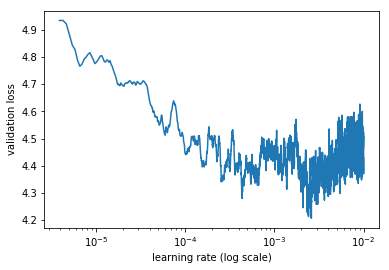

In [24]:
learner.sched.plot()

In [26]:
lrs = 2e-3

In [29]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  0%|          | 31/25599 [00:05<1:21:59,  5.20it/s, loss=3.86]

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                         
    0      3.875623   3.850874   0.353351  
    1      3.830384   3.901042   0.348003                         
    2      3.82486    3.870027   0.351878                         
    3      3.799411   3.849554   0.353899                         
    4      3.730046   3.827109   0.356057                         
    5      3.839701   3.80463    0.358122                         
 34%|███▍      | 8728/25599 [28:20<54:47,  5.13it/s, loss=3.85]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73%|███████▎  | 18564/25599 [1:00:17<22:50,  5.13it/s, loss=3.82]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      3.715381   3.786799   0.359927                         
    7      3.690451   3.770601   0.361826                         
    8      3.680834   3.750456   0.363671                         
    9      3.652806   3.731682   0.366002                         
    10     3.751327   3.714394   0.367879                         
    11     3.72084    3.698541   0.370043                         
    12     3.631057   3.684524   0.372172                         
 16%|█▌        | 4050/25599 [13:08<1:09:53,  5.14it/s, loss=3.62]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55%|█████▍    | 14048/25599 [45:36<37:30,  5.13it/s, loss=3.67]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    13     3.589055   3.671298   0.374148                         
    14     3.538189   3.657976   0.376422                         



[array([3.65798]), 0.3764221608143948]

In [359]:
# The perplexity of this language model after 15 epochs is 38.78
np.exp(3.657976)

38.78276705890738

In [30]:
learner.save('lm_indonesia_final')

In [31]:
learner.save_encoder('lm_indonesia_final_enc')

## Generate sentence using the language model

In [355]:
learner.load('lm_indonesia_final')
seq_rnn = learner.model
seq_rnn.eval()
seq_rnn[0].bs = 1

In [356]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [357]:
def gen_text(ss,topk):
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1,1).cuda()
    t = Variable(t,volatile=False)
    seq_rnn.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [itos[o] for o in to_np(pred_i)]

def generate_sentences(ss,nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1,1).cuda()
    t = Variable(t,volatile=False)
    seq_rnn.reset()
    pred,*_ = seq_rnn(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        word = itos[pred_i.data[0]]
        if word != 'xbos':
            result.append(word)
        else:
            break
        pred,*_ = seq_rnn(pred_i[0].unsqueeze(0))
    
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))
    return(result)

In [386]:
strings = ["jika ibu bersedih sepanjang hari",
           "orang baduy adalah",
           "presiden soekarno adalah",
           "jatuh cinta disebabkan",
           "laki laki jatuh cinta adalah",
           "gadis jatuh cinta disebabkan",
           "seks dan cinta adalah",
           "borobudur adalah warisan",
           "anak balita adalah",
           "ibukota rusia adalah",
           "australia terletak"
          ]

for s in strings:
    print(generate_sentences(s, 80), "\n")
    

jika ibu bersedih sepanjang hari, maka akan terjadi bencana alam yang hebat. 

orang baduy adalah orang - orang yang memiliki kemampuan untuk berbicara dengan orang - orang yang tidak memiliki bahasa. mereka juga memiliki kemampuan untuk berbicara dengan orang lain, dan mereka dapat berbicara dalam bahasa yang berbeda. 

presiden soekarno adalah seorang yang sangat terkenal di indonesia. ia adalah seorang yang sangat cerdas dan memiliki kemampuan untuk menguasai dunia. ia juga memiliki kemampuan untuk menciptakan dan menciptakan sebuah sistem yang dapat digunakan untuk melakukan tugas - tugas yang bersifat khusus. ia juga memiliki kemampuan untuk menciptakan dan mengendalikan berbagai macam bentuk dan kemampuan untuk melakukan hal - hal yang tidak diinginkan. ia juga memiliki kemampuan untuk menciptakan dan mengendalikan sebuah sistem yang dapat mengubah dirinya menjadi sebuah 

jatuh cinta disebabkan oleh adanya perbedaan pendapat mengenai apakah mereka akan melakukan hubungan seksual